<a href="https://colab.research.google.com/github/weireagan/reaganpython/blob/master/VAE%E8%A6%96%E8%A6%BA%E5%8C%96.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x


引入常用套件

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

Layers for FNN

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

Optimizers for training

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

Losses for training

In [0]:
from tensorflow.keras import losses

 data **preprocessing**

In [0]:
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

下載資料集


In [8]:
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

搭建Encoder和Decoder

1.將各層神經元個數做改動

2.將activation function改成tanh、relu、sigmoid

In [0]:
enc_1 = Dense(64, activation='sigmoid')
enc_2 = Dense(128, activation='relu')
enc_3 = Dense(256, activation='tanh')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_4 = Dense(200, activation='relu')
dec_3 = Dense(100, activation='sigmoid')
dec_2 = Dense(150, activation='relu')
dec_1 = Dense(784, activation='sigmoid')

In [0]:
x = Input(shape=(784,))
enc_x = enc_2(enc_1(x))

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

定義抽樣函數

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon 

In [0]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])


In [0]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(dec_3(dec_4(z_input))))

SUMMARY

In [56]:
x_hat = dec_1(dec_2(dec_3(dec_4(z))))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_45 (Dense)                (None, 64)           50240       input_13[0][0]                   
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 128)          8320        dense_45[0][0]                   
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 2)            258         dense_46[0][0]                   
____________________________________________________________________________________________

建立損失函數

In [0]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

訓練模型

In [0]:
VAE.compile(optimizer=Adam())

In [59]:
VAE.fit(X_train, 
        batch_size=128,       # 改變batch_size為128
        epochs=12)            # 訓練次數改為12次

Epoch 1/12
469/469 [==============================] - 4s 9ms/step - loss: 54.2959
Epoch 2/12
469/469 [==============================] - 4s 9ms/step - loss: 47.6938
Epoch 3/12
469/469 [==============================] - 4s 9ms/step - loss: 44.7431
Epoch 4/12
469/469 [==============================] - 4s 9ms/step - loss: 42.9642
Epoch 5/12
469/469 [==============================] - 4s 8ms/step - loss: 41.8248
Epoch 6/12
469/469 [==============================] - 4s 8ms/step - loss: 40.8732
Epoch 7/12
469/469 [==============================] - 4s 8ms/step - loss: 40.1606
Epoch 8/12
469/469 [==============================] - 4s 8ms/step - loss: 39.5002
Epoch 9/12
469/469 [==============================] - 4s 9ms/step - loss: 39.0414
Epoch 10/12
469/469 [==============================] - 4s 9ms/step - loss: 38.6646
Epoch 11/12
469/469 [==============================] - 4s 8ms/step - loss: 38.3087
Epoch 12/12
469/469 [==============================] - 4s 9ms/step - loss: 38.0233


In [60]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_46 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_48 (Dense)             (None, 2)                 258       
Total params: 58,818
Trainable params: 58,818
Non-trainable params: 0
_________________________________________________________________


In [61]:
VAE_Decoder = Model(z_input, dec_1(dec_2(dec_3(dec_4(z_input)))))
VAE_Decoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_50 (Dense)             (None, 200)               600       
_________________________________________________________________
dense_51 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_52 (Dense)             (None, 150)               15150     
_________________________________________________________________
dense_53 (Dense)             (None, 784)               118384    
Total params: 154,234
Trainable params: 154,234
Non-trainable params: 0
_________________________________________________________________


In [0]:
indices = np.random.randint(X_train.shape[0], size=3465) 
VAE_latents = VAE_Encoder.predict(X_train[indices])

In [65]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 55781 圖的 latent 表示為 [-0.1097977  2.014597 ]


VAE視覺化

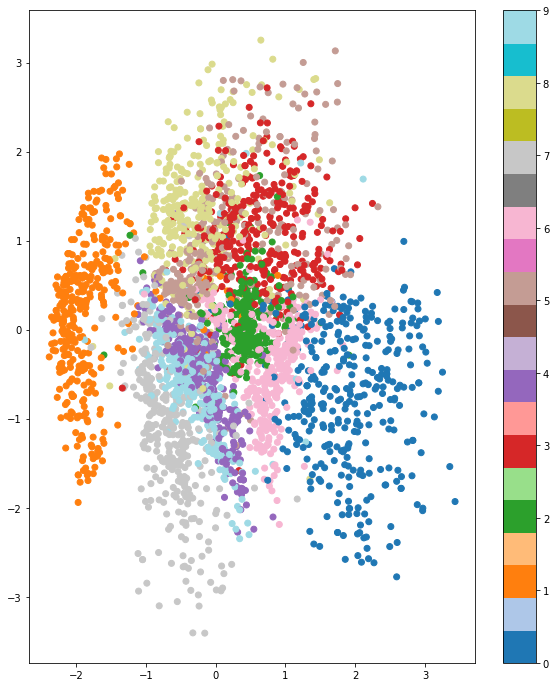

In [68]:
plt.figure(figsize=(10, 12))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [0]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [0]:
n = 16
digit_size = 28

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

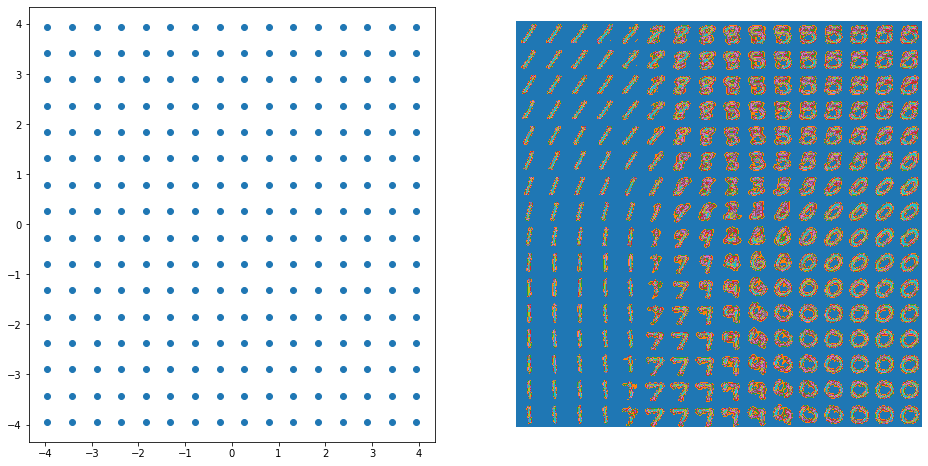

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='tab10')
plt.axis('off')
plt.show()

動態比較

In [0]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [82]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.01,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.inBetween>